# Modelo 1 - ML
### Security Data Science
#### Adrian Rodriguez 21619
#### Jose Daniel Gomez Cabrera 21429

## Exploración de datos

In [121]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold, learning_curve
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc, classification_report, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')

Cargar el dataset

In [122]:
df = pd.read_csv('./data/MalBehavD-V1-dataset.csv')

Obtener muestra de los datos

In [123]:
print(df.head(2))

                                              sha256  labels             0  \
0  5c18291c481a192ed5003084dab2d8a117fd3736359218...       0  LdrUnloadDll   
1  4683faf3da550ffb594cf5513c4cbb34f64df85f27fd1c...       0  NtOpenMutant   

                     1           2                  3                     4  \
0       CoUninitialize  NtQueryKey  NtDuplicateObject     GetShortPathNameW   
1  GetForegroundWindow  NtQueryKey        DrawTextExW  NtSetInformationFile   

                  5                       6                           7  ...  \
0     GetSystemInfo       IsDebuggerPresent  GetSystemWindowsDirectoryW  ...   
1  RegQueryValueExA  LdrGetProcedureAddress              CoUninitialize  ...   

  Unnamed: 167 Unnamed: 168 Unnamed: 169 Unnamed: 170 Unnamed: 171  \
0          NaN          NaN          NaN          NaN          NaN   
1          NaN          NaN          NaN          NaN          NaN   

  Unnamed: 172 Unnamed: 173 Unnamed: 174 Unnamed: 175 Unnamed: 176  
0     

Dimensionalidades e información del dataset

In [124]:
print("\nDimensiones del dataset:", df.shape)
print(df.info())


Dimensiones del dataset: (2570, 177)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2570 entries, 0 to 2569
Columns: 177 entries, sha256 to Unnamed: 176
dtypes: int64(1), object(176)
memory usage: 3.5+ MB
None


Valores unicos en la columna 'labels'

In [125]:
print("\nValores únicos en la columna 'labels':")
print(df['labels'].value_counts())


Valores únicos en la columna 'labels':
labels
0    1285
1    1285
Name: count, dtype: int64


Valores faltantes por columna

In [126]:
print("\nValores faltantes por columna:")
print(df.isnull().sum())


Valores faltantes por columna:
sha256             0
labels             0
0                  0
1                  0
2                  6
                ... 
Unnamed: 172    2569
Unnamed: 173    2569
Unnamed: 174    2569
Unnamed: 175    2569
Unnamed: 176    2569
Length: 177, dtype: int64


Distribucion de las secuencias API

In [127]:
api_counts = {}
for i in range(df.shape[0]):
    # Contar cuántas APIs tiene cada muestra (eliminando NaN)
    row = df.iloc[i, 2:].dropna()
    api_counts[i] = len(row)

In [128]:
print("\nEstadísticas de la cantidad de APIs por muestra:")
api_counts_series = pd.Series(api_counts)
print(api_counts_series.describe())


Estadísticas de la cantidad de APIs por muestra:
count    2570.000000
mean       43.187938
std        29.710582
min         2.000000
25%        20.000000
50%        37.000000
75%        58.000000
max       175.000000
dtype: float64


Visualizamos la cantidad de APIs en funcion de la muestra

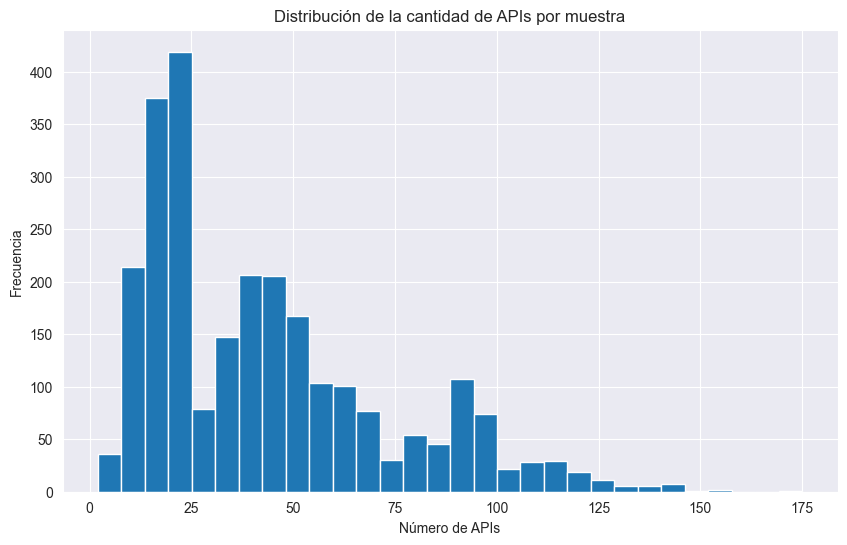

In [129]:
plt.figure(figsize=(10, 6))
plt.hist(api_counts_series, bins=30)
plt.title('Distribución de la cantidad de APIs por muestra')
plt.xlabel('Número de APIs')
plt.ylabel('Frecuencia')
plt.savefig('./data-exploration/api_distribution.png')

Cuales son las APIs más comunes?

In [130]:
all_apis = []
for i in range(df.shape[0]):
    apis = df.iloc[i, 2:].dropna().tolist()
    all_apis.extend(apis)

In [131]:
api_frequency = pd.Series(all_apis).value_counts()

print("\nLas 20 APIs más comunes:")
print(api_frequency.head(20))


Las 20 APIs más comunes:
NtClose                    2524
NtQueryValueKey            2447
NtOpenKey                  2446
LdrGetProcedureAddress     2324
NtCreateFile               2181
NtAllocateVirtualMemory    2173
LdrUnloadDll               2139
RegCloseKey                1936
LdrGetDllHandle            1922
LdrLoadDll                 1894
NtFreeVirtualMemory        1891
GetSystemTimeAsFileTime    1796
NtReadFile                 1596
NtTerminateProcess         1544
NtMapViewOfSection         1539
NtCreateSection            1473
NtWriteFile                1455
RegOpenKeyExW              1433
RegQueryValueExW           1339
GetFileAttributesW         1338
Name: count, dtype: int64


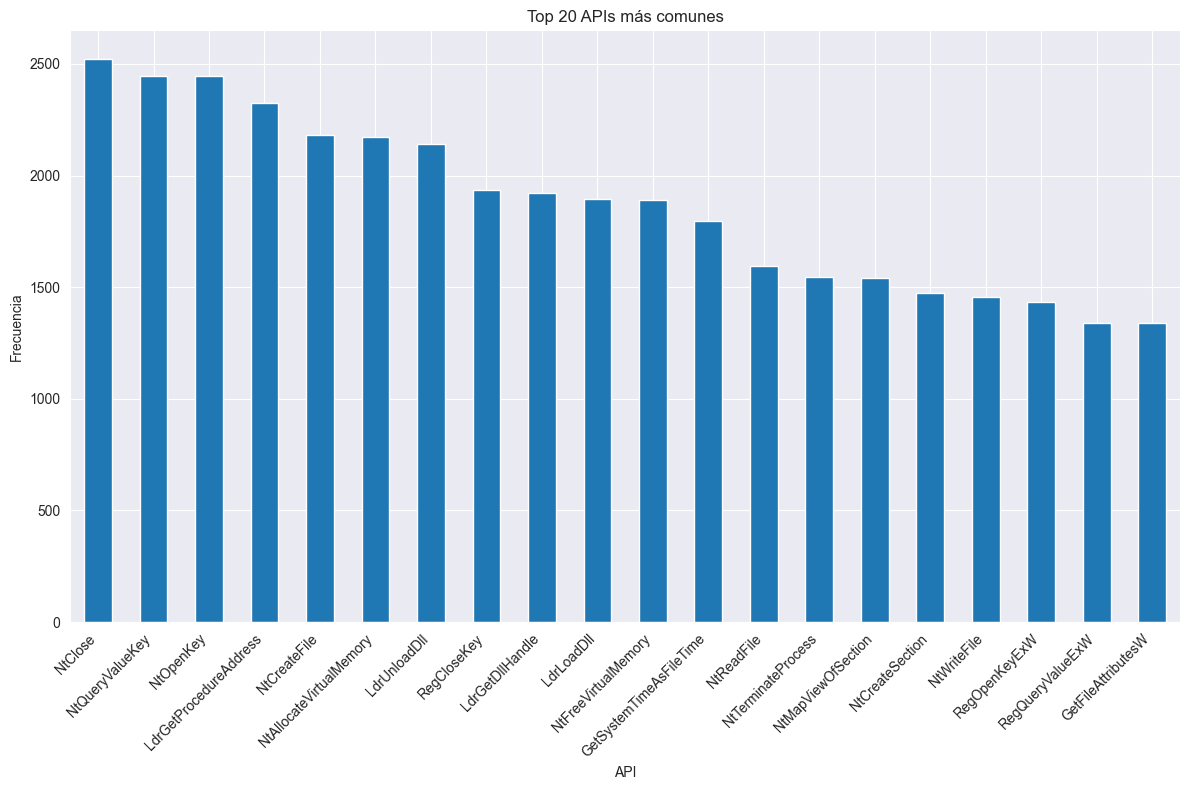

In [132]:
plt.figure(figsize=(12, 8))
api_frequency.head(20).plot(kind='bar')
plt.title('Top 20 APIs más comunes')
plt.xlabel('API')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('./data-exploration/top_apis.png')

## Preprocesamiento

Convertir las secuencias de API en un formato adecuado para el análisis

In [133]:
def create_api_sequences(dataframe):
    sequences = []
    labels = []

    for i in range(dataframe.shape[0]):
        # Extraer las APIs no nulas de cada fila
        apis = dataframe.iloc[i, 2:].dropna().tolist()

        # Convertir la lista de APIs en una cadena, donde cada API está separada por un espacio
        api_sequence = ' '.join(apis)

        sequences.append(api_sequence)
        labels.append(dataframe.iloc[i, 1])  # Columna 'labels'

    return sequences, labels

In [134]:
api_sequences, labels = create_api_sequences(df)

In [135]:
print("Ejemplos de secuencias de API:")
for i in range(3):
    print(f"Muestra {i+1}:")
    print(f"Etiqueta: {labels[i]}")
    print(f"Secuencia: {api_sequences[i][:150]}...")  # Mostrar los primeros 150 caracteres
    print()

Ejemplos de secuencias de API:
Muestra 1:
Etiqueta: 0
Secuencia: LdrUnloadDll CoUninitialize NtQueryKey NtDuplicateObject GetShortPathNameW GetSystemInfo IsDebuggerPresent GetSystemWindowsDirectoryW NtClose GetFileV...

Muestra 2:
Etiqueta: 0
Secuencia: NtOpenMutant GetForegroundWindow NtQueryKey DrawTextExW NtSetInformationFile RegQueryValueExA LdrGetProcedureAddress CoUninitialize NtQueryValueKey Re...

Muestra 3:
Etiqueta: 0
Secuencia: GetForegroundWindow DrawTextExW GetSystemInfo IsDebuggerPresent GetSystemWindowsDirectoryW NtQueryValueKey RegCloseKey GetFileAttributesW RegQueryValu...



## Implementación y validación (70% entrenamiento y 30 pruebas)

In [136]:
# División de datos en conjuntos de entrenamiento y prueba (70/30)
X_train, X_test, y_train, y_test = train_test_split(
    api_sequences, labels, test_size=0.3, random_state=42, stratify=labels
)

In [137]:
print(f"Cantidad de muestras de entrenamiento: {len(X_train)}")
print(f"Cantidad de muestras de prueba: {len(X_test)}")

Cantidad de muestras de entrenamiento: 1799
Cantidad de muestras de prueba: 771


## Ingeniería de Características con BoW (Bag of Words)

In [138]:
bow_vectorizer = CountVectorizer(ngram_range=(1, 1))  # Unigramas
X_train_bow = bow_vectorizer.fit_transform(X_train)
X_test_bow = bow_vectorizer.transform(X_test)

In [139]:
print(f"Dimensiones de X_train_bow: {X_train_bow.shape}")
print(f"Cantidad de características (APIs únicas): {len(bow_vectorizer.get_feature_names_out())}")

Dimensiones de X_train_bow: (1799, 286)
Cantidad de características (APIs únicas): 286


## Ingeniería de Características con TF-IDF

In [140]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2))  # Unigramas y bigramas
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [141]:
print(f"Dimensiones de X_train_tfidf: {X_train_tfidf.shape}")
print(f"Cantidad de características (unigramas y bigramas únicos): {len(tfidf_vectorizer.get_feature_names_out())}")

Dimensiones de X_train_tfidf: (1799, 6754)
Cantidad de características (unigramas y bigramas únicos): 6754


n-gramas más importantes según el valor TF-IDF

In [142]:
feature_names = tfidf_vectorizer.get_feature_names_out()
tfidf_sums = X_train_tfidf.sum(axis=0).A1
top_indices = tfidf_sums.argsort()[-20:]  # Top 20 n-gramas con mayor valor TF-IDF

In [143]:
print("\nTop 20 n-gramas más relevantes según el valor de TF-IDF:")
for idx in top_indices:
    print(f"{feature_names[idx]}: {tfidf_sums[idx]:.4f}")


Top 20 n-gramas más relevantes según el valor de TF-IDF:
ntcreatefile ntclose: 56.3180
ntqueryvaluekey ldrunloaddll: 57.8926
createprocessinternalw: 57.9778
ntopenmutant: 58.7904
getfilesize: 59.3395
getsystemtimeasfiletime: 59.3417
ldrgetdllhandle: 60.1386
ntfreevirtualmemory: 60.1740
ntprotectvirtualmemory: 60.5715
ntwritefile: 60.7630
ntreadfile: 61.6069
regclosekey: 62.6073
ntallocatevirtualmemory: 64.5910
ntcreatefile: 65.5279
ldrgetprocedureaddress: 67.6497
ldrunloaddll: 69.2425
ntqueryvaluekey: 70.0655
ntopenkey: 70.0685
ntclose: 70.5055
ntterminateprocess: 74.2047


Comprobar la distribución de clases en los conjuntos de entrenamiento y prueba

In [144]:
print("Distribución de clases:")
print(f"Entrenamiento: {pd.Series(y_train).value_counts()}")
print(f"Prueba: {pd.Series(y_test).value_counts()}")

Distribución de clases:
Entrenamiento: 1    900
0    899
Name: count, dtype: int64
Prueba: 0    386
1    385
Name: count, dtype: int64


Guardar vectorizadores

In [145]:
pickle.dump(bow_vectorizer, open('./vectorizers/bow_vectorizer.pkl', 'wb'))
pickle.dump(tfidf_vectorizer, open('./vectorizers/tfidf_vectorizer.pkl', 'wb'))

Guardar los preprocesadores

In [146]:
np.save('./preprocessors/X_train_bow.npy', X_train_bow.toarray())
np.save('./preprocessors/X_test_bow.npy', X_test_bow.toarray())
np.save('./preprocessors/X_train_tfidf.npy', X_train_tfidf.toarray())
np.save('./preprocessors/X_test_tfidf.npy', X_test_tfidf.toarray())
np.save('./preprocessors/y_train.npy', np.array(y_train))
np.save('./preprocessors/y_test.npy', np.array(y_test))

## Modelo 1: Random Forest con TF-IDF

In [147]:
X_train_tfidf = np.load('./preprocessors/X_train_tfidf.npy')
X_test_tfidf = np.load('./preprocessors/X_test_tfidf.npy')
y_train = np.load('./preprocessors/y_train.npy')
y_test = np.load('./preprocessors/y_test.npy')

In [148]:
print(f"Dimensiones de X_train_tfidf: {X_train_tfidf.shape}")
print(f"Dimensiones de X_test_tfidf: {X_test_tfidf.shape}")

Dimensiones de X_train_tfidf: (1799, 6754)
Dimensiones de X_test_tfidf: (771, 6754)


classifier de Random Forest

In [149]:
rf_classifier = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    random_state=42,
    n_jobs=-1
)

In [150]:
rf_classifier.fit(X_train_tfidf, y_train)

RandomForestClassifier(max_depth=10, min_samples_split=5, n_jobs=-1,
                       random_state=42)

In [151]:
y_pred = rf_classifier.predict(X_test_tfidf)
y_prob = rf_classifier.predict_proba(X_test_tfidf)[:, 1]

Evaluacion del rendimiento

In [152]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='binary')
recall = recall_score(y_test, y_pred, average='binary')
f1 = f1_score(y_test, y_pred, average='binary')
roc_auc = roc_auc_score(y_test, y_prob)

In [153]:
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

Accuracy: 0.9468
Precision: 0.9886
Recall: 0.9039
F1 Score: 0.9444
ROC AUC: 0.9829


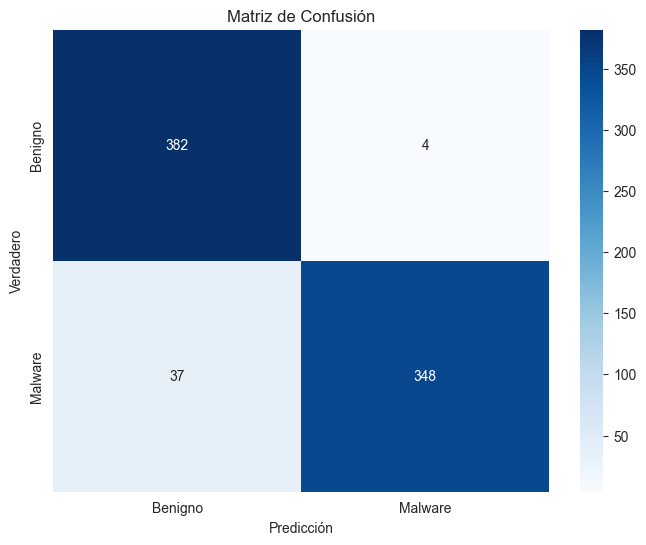

In [154]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Benigno', 'Malware'],
            yticklabels=['Benigno', 'Malware'])
plt.xlabel('Predicción')
plt.ylabel('Verdadero')
plt.title('Matriz de Confusión')
plt.savefig('./model_results/confusion_matrix_model1.png')

Informe  de clasificacion

In [155]:
print("\nInforme de clasificación:")
print(classification_report(y_test, y_pred, target_names=['Benigno', 'Malware']))


Informe de clasificación:
              precision    recall  f1-score   support

     Benigno       0.91      0.99      0.95       386
     Malware       0.99      0.90      0.94       385

    accuracy                           0.95       771
   macro avg       0.95      0.95      0.95       771
weighted avg       0.95      0.95      0.95       771



Curvas de ROC

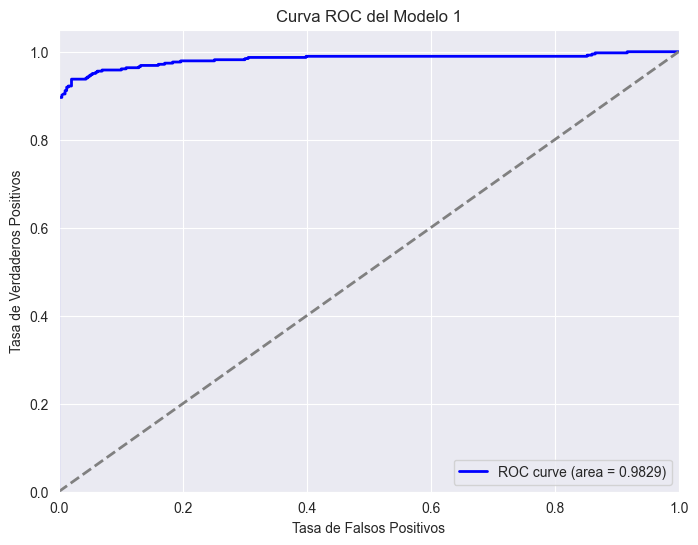

In [156]:
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC del Modelo 1')
plt.legend(loc='lower right')
plt.savefig('./model_results/roc_curve_model1.png')

Validación cruzada K = 10

In [157]:
print("\nRealizando validación cruzada (K=10)...")
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

cv_accuracy = cross_val_score(rf_classifier, X_train_tfidf, y_train, cv=cv, scoring='accuracy')
cv_precision = cross_val_score(rf_classifier, X_train_tfidf, y_train, cv=cv, scoring='precision')
cv_recall = cross_val_score(rf_classifier, X_train_tfidf, y_train, cv=cv, scoring='recall')
cv_f1 = cross_val_score(rf_classifier, X_train_tfidf, y_train, cv=cv, scoring='f1')
cv_roc_auc = cross_val_score(rf_classifier, X_train_tfidf, y_train, cv=cv, scoring='roc_auc')

print(f"CV Accuracy: {cv_accuracy.mean():.4f} (±{cv_accuracy.std():.4f})")
print(f"CV Precision: {cv_precision.mean():.4f} (±{cv_precision.std():.4f})")
print(f"CV Recall: {cv_recall.mean():.4f} (±{cv_recall.std():.4f})")
print(f"CV F1 Score: {cv_f1.mean():.4f} (±{cv_f1.std():.4f})")
print(f"CV ROC AUC: {cv_roc_auc.mean():.4f} (±{cv_roc_auc.std():.4f})")


Realizando validación cruzada (K=10)...
CV Accuracy: 0.9355 (±0.0257)
CV Precision: 0.9839 (±0.0170)
CV Recall: 0.8856 (±0.0445)
CV F1 Score: 0.9317 (±0.0281)
CV ROC AUC: 0.9849 (±0.0092)


Curva de aprendizaje

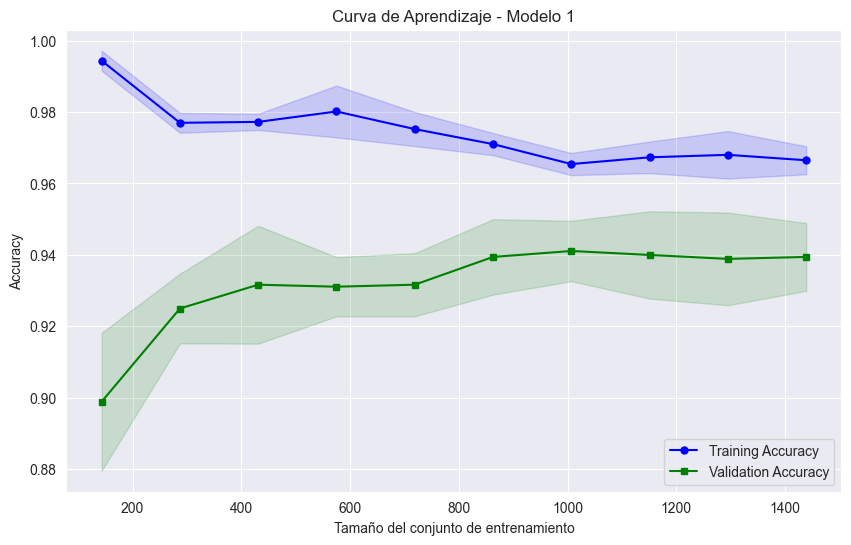

In [158]:
train_sizes, train_scores, test_scores = learning_curve(
    rf_classifier, X_train_tfidf, y_train, cv=5,
    train_sizes=np.linspace(0.1, 1.0, 10), scoring='accuracy'
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training Accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', marker='s', markersize=5, label='Validation Accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.xlabel('Tamaño del conjunto de entrenamiento')
plt.ylabel('Accuracy')
plt.title('Curva de Aprendizaje - Modelo 1')
plt.legend(loc='lower right')
plt.grid(True)
plt.savefig('./model_results/learning_curve_model1.png')

Caracteristicas importantes del Modelo 1

In [159]:
if X_train_tfidf.shape[1] <= 100:  # Si hay demasiadas características, limitamos a las 100 más importantes
    importances = rf_classifier.feature_importances_
    indices = np.argsort(importances)[-20:]  # Top 20 características

    # Cargar el vectorizador para obtener los nombres de las características
    import pickle
    tfidf_vectorizer = pickle.load(open('tfidf_vectorizer.pkl', 'rb'))
    feature_names = tfidf_vectorizer.get_feature_names_out()

    plt.figure(figsize=(12, 8))
    plt.barh(range(len(indices)), importances[indices], align='center')
    plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
    plt.title('Top 20 características más importantes')
    plt.tight_layout()
    plt.savefig('./model_results/feature_importance_model1.png')

    print("\nTop 10 características más importantes:")
    for i in indices[-10:]:
        print(f"{feature_names[i]}: {importances[i]:.6f}")

Guardar modelo en un archivo pickle

In [160]:
pickle.dump(rf_classifier, open('./models/model1_rf_tfidf.pkl', 'wb'))